# Assignment 5
## Due May 28 at 14:00

Please note: 

- Read the instructions in the exercise PDF and in this notebook carefully.
- Add your solutions *only* at `YOUR CODE HERE`/`YOUR ANSWER HERE` and remove the corresponding `raise NotImplementedError()`.
- Do not chance the provided code and text, if not stated.
- Do not *add* or *delete* cells.
- Do not `import` additional functionality. 
- Before submitting: Please make sure, that your notebook can be executed from top to bottom `Menu -> Kernel -> Restart & Run all`. 

In [1]:
import time 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.testing import assert_equal, assert_almost_equal

from sklearn.datasets import load_breast_cancer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#  Hide warnings of LinearSVC, LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

np.random.seed(42)

## a) Know the Dataset


- **Features:** 
    Features are extracted features from the digitized images of breast cancer e.g. volume, grayscale texure, radius etc.
- **Labels:** 
    Features tells whether the tumor is malignant or benign. 

## b) Try a Linear SVM

In [2]:
dataset = load_breast_cancer()

xs = dataset.data
ys = dataset.target

Split `xs, ys` to the training set `xs_train, ys_train` (size $70\%$) and the test set `xs_test, ys_test` (size $30\%$) 

In [3]:
# During the exercises I believe we were told we can use functionality of sklearn like gridsearch so we assumed we can use train_test_split too
# from sklearn.model_selection import train_test_split
# xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.3)
n = xs.shape[0]
train_n = int(np.floor(n*0.7))
perm = np.random.permutation(xs.shape[0])
xs_shuf = xs[perm]
ys_shuf = ys[perm]
xs_train, xs_test, ys_train, ys_test = xs_shuf[:train_n], xs_shuf[train_n:], ys_shuf[:train_n], ys_shuf[train_n:]

# normalization
mean = xs_train.mean(axis=0)
std = xs_train.std(axis=0)
xs_train = (xs_train-mean)/std
xs_test = (xs_test-mean)/std

In [4]:
assert_equal(xs_train.shape, (398, 30))
assert_equal(ys_train.shape, (398,))


Train 50 linear svc estimators with default hyperparameter, but varying the [random_state](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) values. Store these inital state values and the corresponding error on the test set (mean 0-1-loss). 

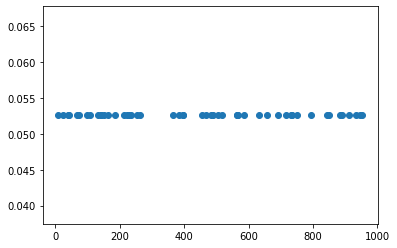

In [5]:
init_states = ...
test_errors = ... 

init_states = np.random.randint(0,1e3,(50))
test_errors = []
for r in init_states:
    s = LinearSVC().fit(xs_train, ys_train)
    test_errors.append(1.0 - s.score(xs_test, ys_test))

plt.scatter(init_states, test_errors)
plt.show()

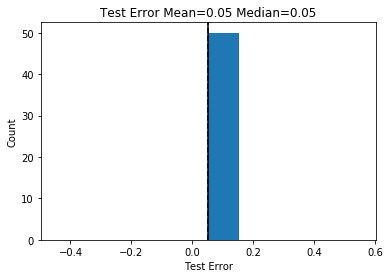

In [6]:
assert len(init_states) == 50
assert len(test_errors) == 50


plt.hist(test_errors)
plt.axvline(np.mean(test_errors), color='k', linestyle='dashed')
plt.axvline(np.median(test_errors), color='k')
plt.xlabel('Test Error')
plt.ylabel('Count')
plt.title(f"Test Error Mean={np.mean(test_errors):.2f} Median={np.median(test_errors):.2f}")
plt.show()

## c) Optimize the Hyperparameter

Find good hyperparameter *without* the test set.

In [7]:
%%time
# DO NOT USE xs_test, ys_test here!
# Please make your optimization reproducable (e.g. set random_state, seed, …)

best_params = {}

# YOUR CODE HERE
from sklearn.model_selection import GridSearchCV, cross_validate

params = {'C': [0.0001, 0.001, 0.002, 0.004, 0.008, 0.01, 0.1], 'max_iter':[1000,10000,100000], 'random_state':[632463246]}
s = LinearSVC()

clf = GridSearchCV(s, params)
clf.fit(xs_train, ys_train)
best_params = clf.best_params_
print(best_params)

best_estimator = LinearSVC(**best_params).fit(xs_train, ys_train)

cv_res = cross_validate(best_estimator, xs_train, ys_train, cv=5)
risk = 1.0 - cv_res['test_score'].mean()
print(risk)

{'C': 0.01, 'max_iter': 1000, 'random_state': 632463246}
0.017626582278481018
CPU times: user 82.6 ms, sys: 188 µs, total: 82.8 ms
Wall time: 81.2 ms


In [8]:
assert isinstance(best_estimator, LinearSVC)
assert best_params != {}

second_estimator = LinearSVC(**best_params).fit(xs_train, ys_train)
assert_equal(best_estimator.predict(xs_test), second_estimator.predict(xs_test))

In [9]:
test_error = np.mean(best_estimator.predict(xs_test) != ys_test)
assert test_error < 0.09

In [10]:
assert test_error < 0.06

## d) Linear SVM vs Logistic Regression

Train a logistic regression estimator and compare it to the best svm estimator above.

In [11]:
# if you did not solve c), use this:
# svm_estimator = LinearSVC(C=0.002, random_state=42).fit(xs_train, ys_train)
# else, use this:
svm_estimator = best_estimator  

logreg = LogisticRegression().fit(xs_train, ys_train)

print(f'Test errors:\nSVM {(svm_estimator.predict(xs_test) != ys_test).mean()}\nLogReg {(logreg.predict(xs_test) != ys_test).mean()}')

Test errors:
SVM 0.04678362573099415
LogReg 0.04678362573099415


Compare the models. Which model would you choose and why?

Cosidering that we are not using kernel svm, both methods are linear and have similar results (at least when the data is normalized which aids the optimisation).

## e) State concerns

1. **Ethical:** 
    Since the application is in medical domain, we are concerned with classifing people that have malignant cancer in benign group, as that would lead to a most likely life threatening consequences.
2. **Technical/Statistical:**
    Data set is arguably small, and the results thus do not have to be significant. Also we are using linear methods - which in this case work surprisingly well - but we were already given extracted features. If were to apply linear classifier on the raw imaging data, results would be much worse.
3. **Any:**
    We are not aware how realiable feature extraction process was.